In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

## 读入数据

In [2]:
train_df = pd.read_csv('../input/train.csv')

test_df = pd.read_csv('../input/test.csv')

In [3]:
train_df.shape[0], test_df.shape[0]

(90615, 60411)

## 特征工程

In [4]:
com_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

train_idx = com_df.index[:train_df.shape[0]]
test_idx = com_df.index[train_df.shape[0]:]

In [5]:
Sex2code = {'I': 0, 'M': 1, 'F': 2}
com_df['Sex_code'] = com_df['Sex'].map(Sex2code)

In [6]:
com_df['Rings_log1p'] = np.log1p(com_df['Rings'])

In [7]:
train_df = com_df.loc[train_idx]
test_df = com_df.loc[test_idx]

In [9]:
train_cols = [c for c in train_df.columns if c not in {'id', 'Rings', 'Rings_log1p', 'Sex'}]

In [10]:
train_cols

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Sex_code']

In [11]:
target_col = 'Rings'

## 建模

### 数据集划分

In [13]:
trn_idx, val_idx = train_test_split(train_df.index, test_size=0.2, random_state=42)

In [14]:
len(trn_idx), len(val_idx)

(72492, 18123)

### lgb

In [32]:
trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], train_df.loc[trn_idx, target_col], categorical_feature=['Sex_code'])
val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], train_df.loc[val_idx, target_col], categorical_feature=['Sex_code'])

In [33]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 1.0,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [34]:
model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(200)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.697111
Training until validation scores don't improve for 400 rounds
[200]	valid_0's l2: 3.50777
[400]	valid_0's l2: 3.46045
[600]	valid_0's l2: 3.44399
[800]	valid_0's l2: 3.42847
[1000]	valid_0's l2: 3.42392
[1200]	valid_0's l2: 3.42476
Early stopping, best iteration is:
[995]	valid_0's l2: 3.42334


In [35]:
oof = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)

In [36]:
mean_squared_log_error(train_df.loc[val_idx, 'Rings'], oof, squared=False)

0.1509937174166167

### NN

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 网络搭建

In [38]:
class SimpleRegressionNet(nn.Module):
    def __init__(self, embedding_sizes, num_numeric_features, output_size, hidden_layers):
        '''
        embedding_sizes: [(num_cat1, emb_size1), ...]
        num_numeric_features: integer
        output_size: integer
        hidden_layers: list of integer
        '''
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_cat, size) for num_cat, size in embedding_sizes
        ])
        num_embeddings_out = sum(e.embedding_dim for e in self.embeddings)
        
        self.fc_layers = nn.Sequential()
        input_size = num_numeric_features + num_embeddings_out
        for i, hidden_size in enumerate(hidden_layers):
            self.fc_layers.add_module(f'fc{i}', nn.Linear(input_size, hidden_size))
            self.fc_layers.add_module(f'relu{i}', nn.ReLU())
            input_size = hidden_size
        
        self.output_layer = nn.Linear(input_size, output_size)
    
    def forward(self, x_numeric, x_categorical):
        embeddings = [embedding(cat) for embedding, cat in zip(self.embeddings, x_categorical)]
        x_embedding = torch.cat(embeddings, 1)
        x = torch.cat((x_embedding, x_numeric), 1)
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

In [41]:
embedding_sizes = [
    (3, 4)    # Sex_code 有三个取值 M / F / I; 对于简单数据，embedding size设小一点，比如4
]

num_numeric_features = len(train_cols) - 1

output_size = 1    # 回归模型，映射到一个值上

hidden_layers = [32, 16]    # 两层隐藏层

model = SimpleRegressionNet(embedding_sizes, num_numeric_features, output_size, hidden_layers)

In [65]:
# 取一部分数据做测试
numeric_feats = [c for c in train_cols if c != 'Sex_code']
categorical_feats = ['Sex_code']

batch_size = 4
x_numeric = torch.tensor(train_df[numeric_feats].values[:batch_size], dtype=torch.float32)
x_categorical = torch.tensor(train_df[categorical_feats].values[:batch_size].transpose(1, 0), dtype=torch.long)

In [66]:
x_numeric.size(), x_categorical.size()

(torch.Size([4, 7]), torch.Size([1, 4]))

In [67]:
output = model(x_numeric, x_categorical)

In [68]:
output

tensor([[-0.1078],
        [-0.1070],
        [-0.1155],
        [-0.1096]], grad_fn=<AddmmBackward0>)

#### dataloader

In [69]:
from torch.utils.data.dataset import Dataset

In [86]:
from torch.utils.data import DataLoader

In [78]:
class AbaloneDataset(Dataset):
    def __init__(self, train_df, numeric_feats, categorical_feats, trn_idx, val_idx, mode):
        target_idx = trn_idx if mode == 'train' else val_idx
        self.numeric_data = train_df.loc[target_idx, numeric_feats].values
        self.categorical_data = train_df.loc[target_idx, categorical_feats].values
        self.target = train_df.loc[target_idx, 'Rings'].values
        
    
    def __len__(self):
        return self.numeric_data.shape[0]
    
    def __getitem__(self, i):
        return {
            'x_numeric': self.numeric_data[i],
            'x_categorical': self.categorical_data[i],
            'y': self.target[i],
        }

In [79]:
train_data = AbaloneDataset(
    train_df, 
    numeric_feats, 
    categorical_feats,
    trn_idx,
    val_idx,
    mode='train',
)

In [80]:
val_data = AbaloneDataset(
    train_df, 
    numeric_feats, 
    categorical_feats,
    trn_idx,
    val_idx,
    mode='val',
)

In [120]:
batch_size = 1024

In [121]:
def data_collator(features):
    batch = {}
    batch['x_numeric'] = torch.tensor([f['x_numeric'] for f in features], dtype=torch.float32)
    
    x_categorical = np.vstack([f['x_categorical'] for f in features]).transpose(1, 0)
    batch['x_categorical'] = torch.tensor(x_categorical, dtype=torch.long)
    
    batch['y'] = torch.tensor([f['y'] for f in features], dtype=torch.float32)
    
    return batch

In [122]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

In [123]:
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

#### 训练

In [153]:
model = SimpleRegressionNet(embedding_sizes, num_numeric_features, output_size, hidden_layers)

In [154]:
# 设置device，优先使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleRegressionNet(
  (embeddings): ModuleList(
    (0): Embedding(3, 4)
  )
  (fc_layers): Sequential(
    (fc0): Linear(in_features=11, out_features=32, bias=True)
    (relu0): ReLU()
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (relu1): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [155]:
# 定义损失函数和优化器
criterion = nn.MSELoss()  # 回归问题常用的均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [156]:
# 设置训练的epochs
epochs = 200
train_loss = []
val_rmsle = []
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    total_loss = 0
    for batch in train_loader:
        x_numeric = batch['x_numeric']
        x_categorical = batch['x_categorical']
        targets = batch['y']
        
        x_numeric = x_numeric.to(device)
        x_categorical = [x.to(device) for x in x_categorical]
        targets = targets.to(device).view(-1, 1)  # 确保targets维度与模型输出一致

        optimizer.zero_grad()  # 清空过往梯度
        outputs = model(x_numeric, x_categorical)  # 前向传播，获取输出
        loss = criterion(outputs, targets)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 根据梯度更新网络参数

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    train_loss.append(total_loss/len(train_loader))
    
    # 验证阶段，我们将计算并打印验证集上的 RMSLE 损失
    model.eval()  # 设置模型为评估模式
    all_label = []
    all_pred = []
    with torch.no_grad():
        for batch in val_loader:
            x_numeric = batch['x_numeric']
            x_categorical = batch['x_categorical']
            targets = batch['y']
            all_label.append(targets.numpy())

            x_numeric = x_numeric.to(device)
            x_categorical = [x.to(device) for x in x_categorical]
            outputs = model(x_numeric, x_categorical)
            
            outputs = outputs.detach().cpu().numpy()
            all_pred.append(outputs.squeeze())

    all_label = np.concatenate(all_label)
    all_pred = np.concatenate(all_pred)

    rmsle = mean_squared_log_error(all_label, all_pred, squared=False)
    val_rmsle.append(rmsle)

    print(f"Val RMSLE: {rmsle}\n")

Epoch 1/200, Loss: 95.85523836377641
Val RMSLE: 1.433043360710144

Epoch 2/200, Loss: 34.69235839306469
Val RMSLE: 0.2850308120250702

Epoch 3/200, Loss: 8.287937298626966
Val RMSLE: 0.20913471281528473

Epoch 4/200, Loss: 6.0997894515453925
Val RMSLE: 0.19742609560489655

Epoch 5/200, Loss: 5.829071696375458
Val RMSLE: 0.19684842228889465

Epoch 6/200, Loss: 5.77192325995002
Val RMSLE: 0.19690431654453278

Epoch 7/200, Loss: 5.732550715056943
Val RMSLE: 0.19510096311569214

Epoch 8/200, Loss: 5.687398520993515
Val RMSLE: 0.1951582133769989

Epoch 9/200, Loss: 5.6453459833709285
Val RMSLE: 0.19459585845470428

Epoch 10/200, Loss: 5.60284720676046
Val RMSLE: 0.1936207413673401

Epoch 11/200, Loss: 5.554596088301968
Val RMSLE: 0.1926184594631195

Epoch 12/200, Loss: 5.489132249859018
Val RMSLE: 0.19283244013786316

Epoch 13/200, Loss: 5.420832345183467
Val RMSLE: 0.19119460880756378

Epoch 14/200, Loss: 5.349985619665871
Val RMSLE: 0.18977122008800507

Epoch 15/200, Loss: 5.2714110898299

Epoch 118/200, Loss: 3.6504028313596484
Val RMSLE: 0.15825197100639343

Epoch 119/200, Loss: 3.6484573760502776
Val RMSLE: 0.15844100713729858

Epoch 120/200, Loss: 3.6426312889851316
Val RMSLE: 0.158634215593338

Epoch 121/200, Loss: 3.6444547478581817
Val RMSLE: 0.15843123197555542

Epoch 122/200, Loss: 3.640280031822097
Val RMSLE: 0.15932051837444305

Epoch 123/200, Loss: 3.637916749631855
Val RMSLE: 0.1583409607410431

Epoch 124/200, Loss: 3.639391318173476
Val RMSLE: 0.15842384099960327

Epoch 125/200, Loss: 3.6401586633333016
Val RMSLE: 0.15935368835926056

Epoch 126/200, Loss: 3.6452722683758805
Val RMSLE: 0.15828865766525269

Epoch 127/200, Loss: 3.6421586224730587
Val RMSLE: 0.1582944393157959

Epoch 128/200, Loss: 3.638798283859038
Val RMSLE: 0.1581742763519287

Epoch 129/200, Loss: 3.6347125113849907
Val RMSLE: 0.1603325754404068

Epoch 130/200, Loss: 3.6373529937905325
Val RMSLE: 0.15877017378807068

Epoch 131/200, Loss: 3.637089789753229
Val RMSLE: 0.15849409997463226

Epo

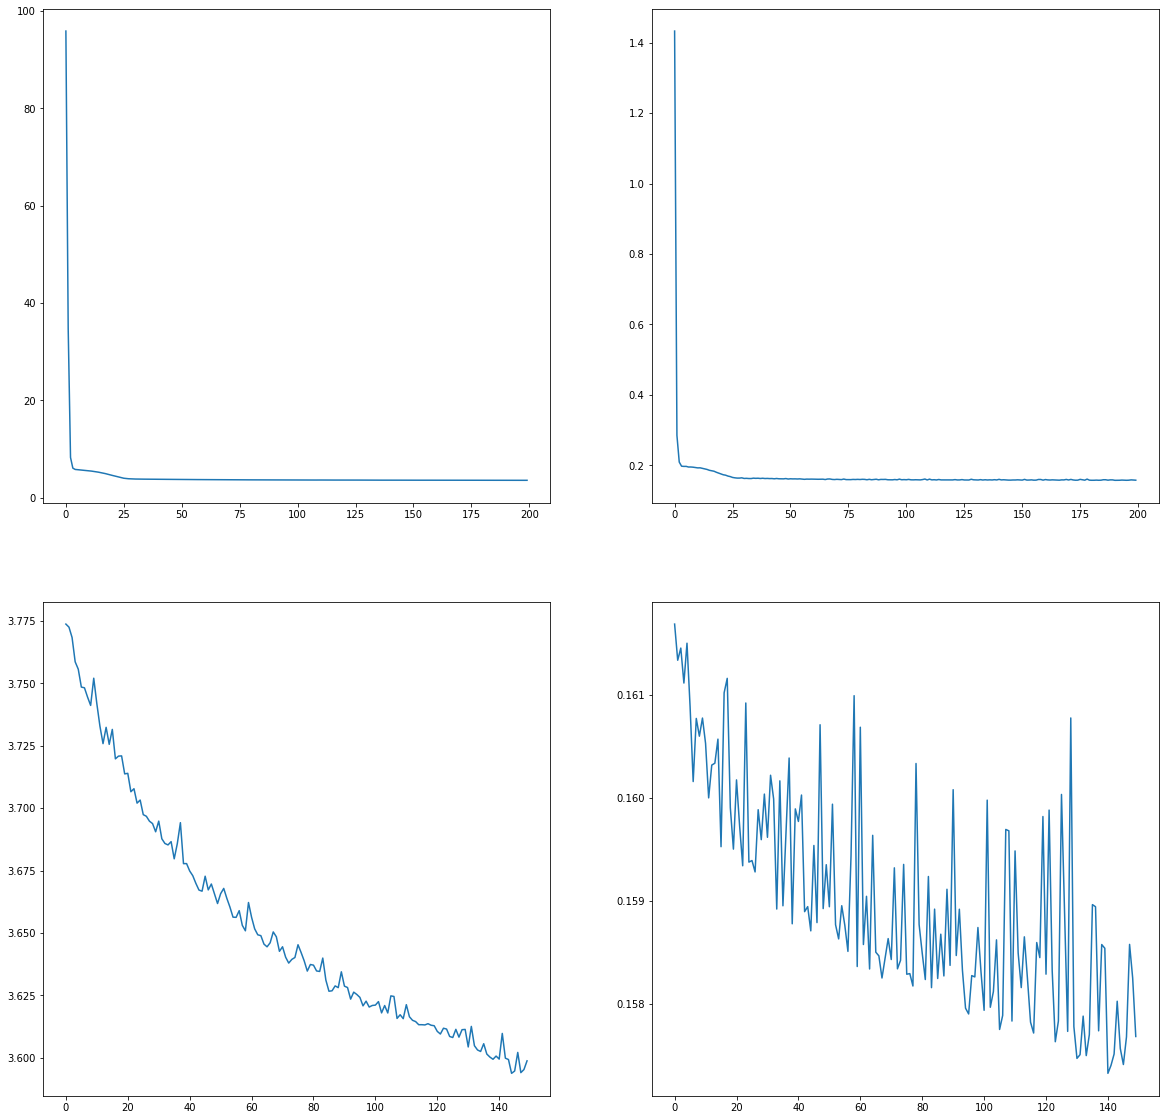

In [159]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(train_loss)
plt.title('train loss')

plt.subplot(2, 2, 2)
plt.plot(val_rmsle)
plt.title('train loss')

plt.subplot(2, 2, 3)
plt.plot(train_loss[50:])

plt.subplot(2, 2, 4)
plt.plot(val_rmsle[50:])

### tabnet

In [1]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

In [3]:
TabNetRegressor.save_model?

Signature: TabNetRegressor.save_model(self, path)
Docstring:
Saving TabNet model in two distinct files.

Parameters
----------
path : str
    Path of the model.

Returns
-------
str
    input filepath with ".zip" appended
File:      ~/opt/miniconda3/envs/py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py
Type:      function

In [5]:
TabNetRegressor.load_model??

Signature: TabNetRegressor.load_model(self, filepath)
Source:   
    def load_model(self, filepath):
        """Load TabNet model.

        Parameters
        ----------
        filepath : str
            Path of the model.
        """
        try:
            with zipfile.ZipFile(filepath) as z:
                with z.open("model_params.json") as f:
                    loaded_params = json.load(f)
                    loaded_params["init_params"]["device_name"] = self.device_name
                with z.open("network.pt") as f:
                    try:
                        saved_state_dict = torch.load(f, map_location=self.device)
                    except io.UnsupportedOperation:
                        # In Python <3.7, the returned file object is not seekable (which at least
                        # some versions of PyTorch require) - so we'll try buffering it in to a
                        # BytesIO instead:
                        saved_state_dict = torch.load(
              

In [162]:
cat_idxs = [i for i, c in enumerate(train_cols) if c == 'Sex_code']

In [163]:
cat_idxs

[7]

In [164]:
cat_dims = [3]

In [165]:
X_train = train_df.loc[trn_idx, train_cols].values
y_train = train_df.loc[trn_idx, target_col].values.reshape(-1, 1)
X_valid = train_df.loc[val_idx, train_cols].values
y_valid = train_df.loc[val_idx, target_col].values.reshape(-1, 1)

In [167]:
X_train.shape, X_valid.shape

((72492, 8), (18123, 8))

In [169]:
# Network parameters
max_epochs = 100
batch_size = 1280
clf = TabNetRegressor(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=[4],
                       lambda_sparse=0.0,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(X_train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                      )

/usr/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [170]:
%%time

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['val'],
    eval_metric=['rmsle'],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    # weights=1,
    drop_last=False,
    # loss_fn=my_loss_fn
) 


/usr/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 61.34516| val_rmsle: 0.57099 |  0:00:03s
epoch 1  | loss: 20.52963| val_rmsle: 0.23028 |  0:00:07s
epoch 2  | loss: 4.84183 | val_rmsle: 0.23711 |  0:00:11s
epoch 3  | loss: 3.95201 | val_rmsle: 0.21292 |  0:00:15s
epoch 4  | loss: 3.78489 | val_rmsle: 0.20138 |  0:00:19s
epoch 5  | loss: 3.73601 | val_rmsle: 0.19574 |  0:00:23s
epoch 6  | loss: 3.69652 | val_rmsle: 0.18809 |  0:00:27s
epoch 7  | loss: 3.66143 | val_rmsle: 0.17817 |  0:00:30s
epoch 8  | loss: 3.64518 | val_rmsle: 0.1717  |  0:00:34s
epoch 9  | loss: 3.6414  | val_rmsle: 0.16108 |  0:00:38s
epoch 10 | loss: 3.66963 | val_rmsle: 0.15674 |  0:00:41s
epoch 11 | loss: 3.66105 | val_rmsle: 0.16151 |  0:00:45s
epoch 12 | loss: 3.64493 | val_rmsle: 0.15738 |  0:00:49s
epoch 13 | loss: 3.62859 | val_rmsle: 0.15903 |  0:00:52s
epoch 14 | loss: 3.63229 | val_rmsle: 0.15733 |  0:00:56s
epoch 15 | loss: 3.66585 | val_rmsle: 0.15635 |  0:01:00s
epoch 16 | loss: 3.6354  | val_rmsle: 0.15824 |  0:01:04s
epoch 17 | los

In [171]:
tnet_val_pred = clf.predict(X_valid)

In [173]:
mean_squared_log_error(y_valid, np.clip(tnet_val_pred, 0, 30), squared=False)

0.15330114515001073

In [180]:
train_loss = np.array(clf.history['loss'])
val_rmsle = np.array(clf.history['val_rmsle'])

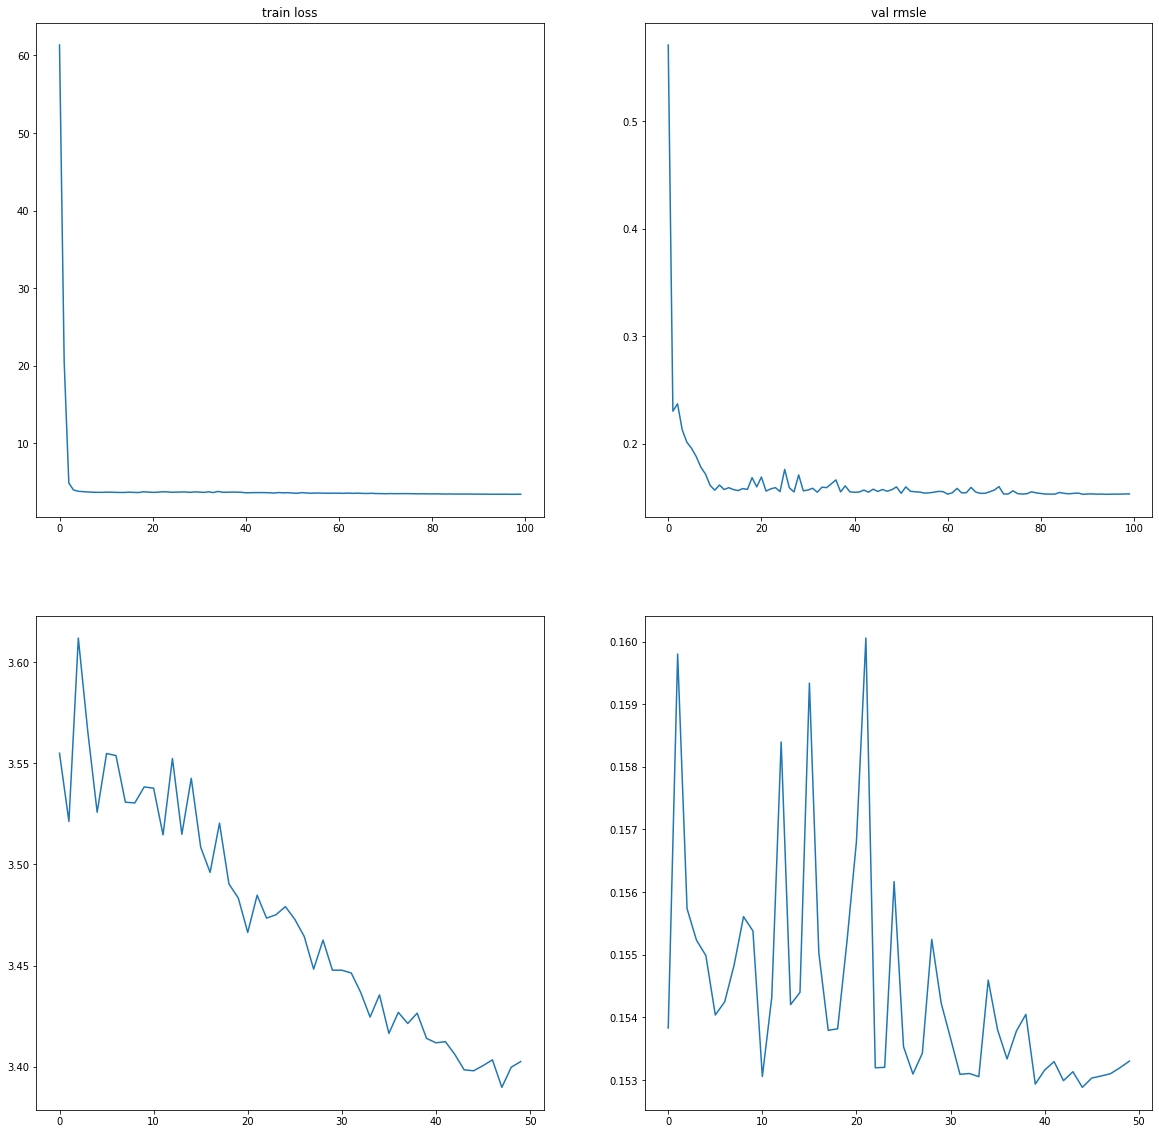

In [182]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(train_loss)
plt.title('train loss')

plt.subplot(2, 2, 2)
plt.plot(val_rmsle)
plt.title('val rmsle')

plt.subplot(2, 2, 3)
plt.plot(train_loss[50:])

plt.subplot(2, 2, 4)
plt.plot(val_rmsle[50:])

#### tabnet调参

python3 bayesHyperTuning.py tn